In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Regression</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svr_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_reg_bias' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_reg_bias']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'reg_bias')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'unreg_bias')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
        
    filtered_cv_results[['C', 'epsilon', 'fit_time', 'r2', 'n_iter']] = cv_results[[
        'param_C', 'param_epsilon', 'mean_fit_time', 'mean_train_r2', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)
    
    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [5]:
from sklearn.datasets import make_regression
from optiml.ml.utils import generate_nonlinearly_regression_data

lin_X, lin_y = make_regression(n_samples=100, n_features=1, noise=10, bias=2, random_state=2)
nonlin_X, nonlin_y = generate_nonlinearly_regression_data(random_state=123456)

## Epsilon-insensitive loss

### Primal formulation

In [6]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [44]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def primal_r2_scorer(svr, X, y):
    if hasattr(svr, 'train_loss_history'):
        train_loss_history[svr.momentum_type][svr.C][svr.epsilon] = svr.train_loss_history
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.epoch, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 1 folds for each of 9 candidates, totalling 9 fits


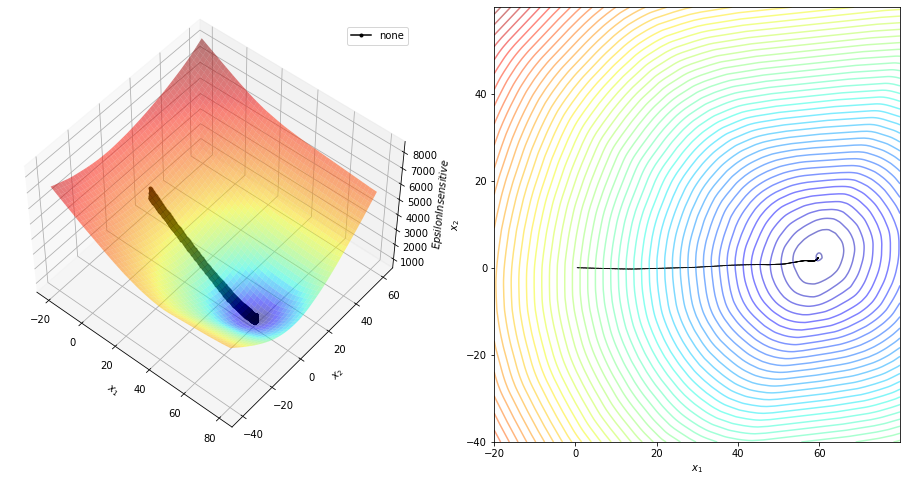

In [45]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
eps_loss_opt = plot_trajectory_optimization(eps_loss, grid.best_estimator_.optimizer, 
                                            color='k', label='none')

In [46]:
none_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
none_primal_svr_eps_cv_results.insert(1, 'momentum', 'none')
none_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      1.735227  0.119916    1000   100
                    0.2      1.467583  0.119916    1000   100
                    0.3      1.539741  0.119916    1000   100
                10  0.1      1.835003  0.815212    1000   100
                    0.2      1.586112  0.815222    1000   100
                    0.3      1.484237  0.815215    1000    99
                100 0.1      0.417207  0.977561     261    99
                    0.2      0.443408  0.977558     271    99
                    0.3      0.386817  0.977558     270    97

Fitting 1 folds for each of 9 candidates, totalling 9 fits


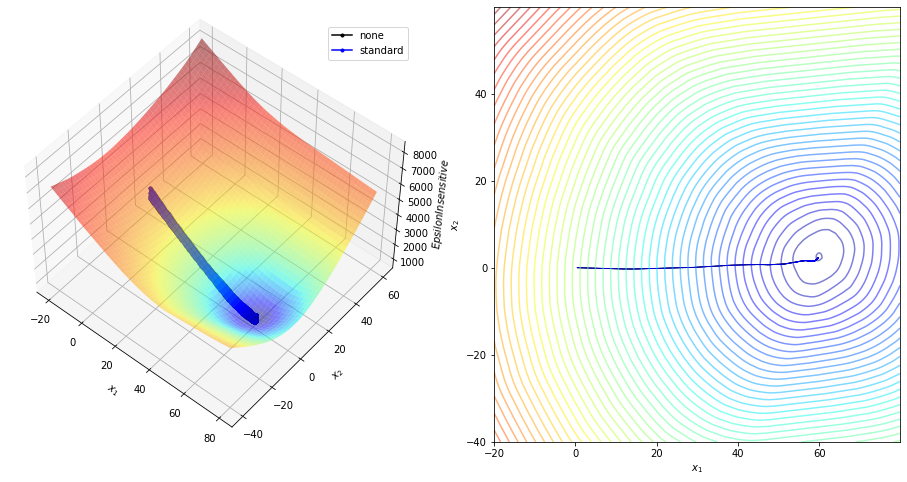

In [47]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='standard', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='b', label='standard')
eps_loss_opt

In [48]:
standard_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svr_eps_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
standard_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    standard 1   0.1      1.584653  0.176352    1000   100
                    0.2      1.318829  0.176352    1000   100
                    0.3      1.306618  0.176352    1000   100
                10  0.1      1.484410  0.954799    1000    98
                    0.2      1.428674  0.954776    1000    97
                    0.3      1.459650  0.954761    1000    96
                100 0.1      0.235501  0.977561     158    99
                    0.2      0.232048  0.977558     163    99
                    0.3      0.244266  0.977553     177    97

Fitting 1 folds for each of 9 candidates, totalling 9 fits


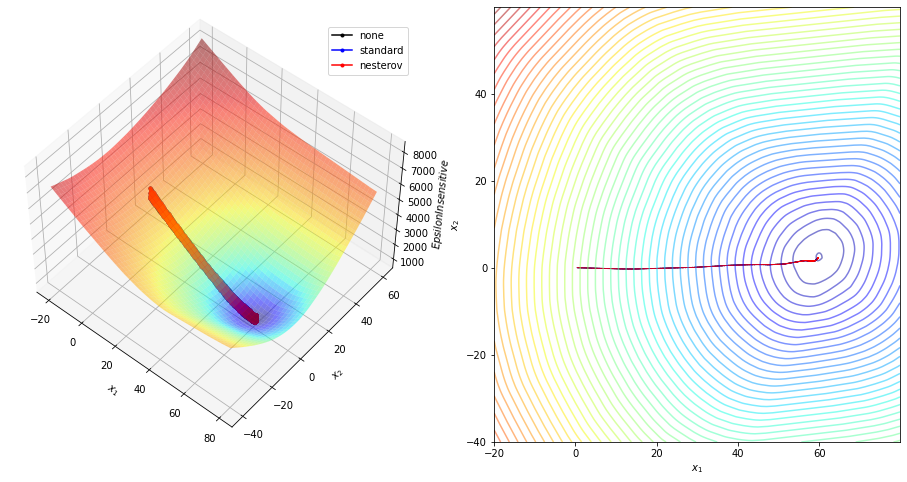

In [49]:
grid = GridSearchCV(PrimalSVR(loss=epsilon_insensitive, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='nesterov', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

eps_loss_opt = plot_trajectory_optimization(eps_loss_opt, grid.best_estimator_.optimizer, 
                                            color='r', label='nesterov')
eps_loss_opt.savefig('./tex/img/svr_eps_loss.png')
eps_loss_opt

In [50]:
nesterov_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svr_eps_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svr_eps_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      1.740966  0.176347    1000   100
                    0.2      1.446091  0.176347    1000   100
                    0.3      1.394688  0.176347    1000   100
                10  0.1      1.653226  0.954791    1000    98
                    0.2      1.506132  0.954768    1000    97
                    0.3      1.549500  0.954752    1000    96
                100 0.1      0.212717  0.977562     158    99
                    0.2      0.332365  0.977558     164   100
                    0.3      0.246243  0.977553     176    98

In [51]:
custom_primal_svr_eps_cv_results = none_primal_svr_eps_cv_results.append(
    standard_primal_svr_eps_cv_results).append(
    nesterov_primal_svr_eps_cv_results)
custom_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      1.735227  0.119916    1000   100
                    0.2      1.467583  0.119916    1000   100
                    0.3      1.539741  0.119916    1000   100
                10  0.1      1.835003  0.815212    1000   100
                    0.2      1.586112  0.815222    1000   100
                    0.3      1.484237  0.815215    1000    99
                100 0.1      0.417207  0.977561     261    99
                    0.2      0.443408  0.977558     271    99
                    0.3      0.386817  0.977558     270    97
       standard 1   0.1      1.584653  0.176352    1000   100
                    0.2      1.318829  0.176352    1000   100
                    0.3      1.306618  0.176352    1000   100
                10  0.1      1.484410  0.954799    1000    98
                    0.2      1.428674  0.954776    1000    97
                    0.3      1.459650  0.954761    1000    96
                100 0.1      0.235501  0.977561     158    99
                    0.2      0.232048  0.977558     163    99
                    0.3      0.244266  0.977553     177    97
       nesterov 1   0.1      1.740966  0.176347    1000   100
                    0.2      1.446091  0.176347    1000   100
                    0.3      1.394688  0.176347    1000   100
                10  0.1      1.653226  0.954791    1000    98
                    0.2      1.506132  0.954768    1000    97
                    0.3      1.549500  0.954752    1000    96
                100 0.1      0.212717  0.977562     158    99
                    0.2      0.332365  0.977558     164   100
                    0.3      0.246243  0.977553     176    98

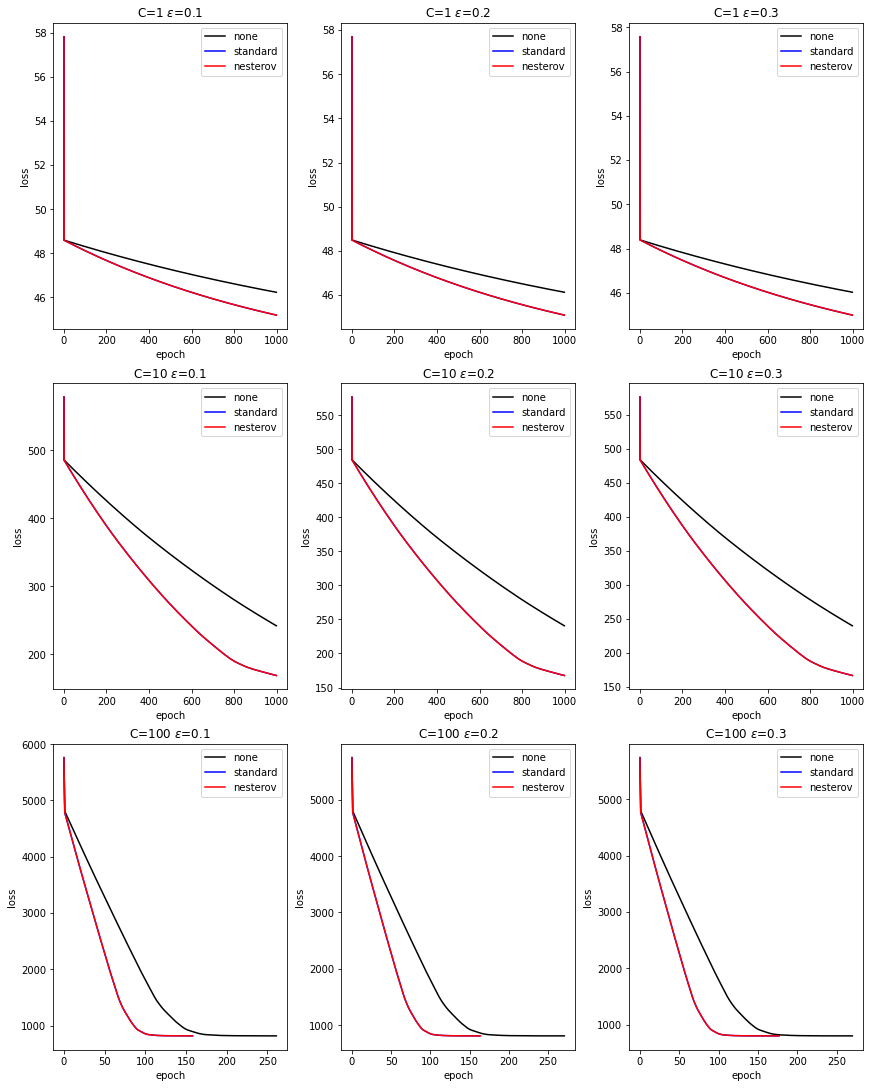

In [52]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for momentum, _dict1 in train_loss_history.items():
    for (C, _dict2), row_ax in zip(_dict1.items(), axes):
        for (eps, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[momentum])
            loss.set_title('C={:d} $\epsilon$={:.1f}'.format(C, eps))
            loss.set_xlabel('epoch')
            loss.set_ylabel('loss')
            loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/svr_eps_loss_history.png')

In [53]:
grid = GridSearchCV(SkLinearSVR(loss='epsilon_insensitive', random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [54]:
liblinear_primal_svr_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.001412  0.964163      12    97
                       0.2      0.000964  0.963786      12    97
                       0.3      0.001528  0.963443      18    95
                   10  0.1      0.001472  0.977559     111   100
                       0.2      0.001027  0.977552     126    99
                       0.3      0.001025  0.977564     253    98
                   100 0.1      0.001641  0.977481     672    99
                       0.2      0.001544  0.977442     881    99
                       0.3      0.002051  0.977458    1000    98

In [55]:
primal_svr_eps_cv_results = custom_primal_svr_eps_cv_results.append(liblinear_primal_svr_eps_cv_results)
primal_svr_eps_cv_results.to_latex('./tex/experiments/primal_svr_eps.tex', 
                                   caption='SVR Primal formulation results with Epsilon-insensitive loss', 
                                   label='primal_svr_eps_cv_results', position='H')
primal_svr_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      1.735227  0.119916    1000   100
                       0.2      1.467583  0.119916    1000   100
                       0.3      1.539741  0.119916    1000   100
                   10  0.1      1.835003  0.815212    1000   100
                       0.2      1.586112  0.815222    1000   100
                       0.3      1.484237  0.815215    1000    99
                   100 0.1      0.417207  0.977561     261    99
                       0.2      0.443408  0.977558     271    99
                       0.3      0.386817  0.977558     270    97
          standard 1   0.1      1.584653  0.176352    1000   100
                       0.2      1.318829  0.176352    1000   100
                       0.3      1.306618  0.176352    1000   100
                   10  0.1      1.484410  0.954799    1000    98
                       0.2      1.428674  0.954776    1000    97
                       0.3      1.459650  0.954761    1000    96
                   100 0.1      0.235501  0.977561     158    99
                       0.2      0.232048  0.977558     163    99
                       0.3      0.244266  0.977553     177    97
          nesterov 1   0.1      1.740966  0.176347    1000   100
                       0.2      1.446091  0.176347    1000   100
                       0.3      1.394688  0.176347    1000   100
                   10  0.1      1.653226  0.954791    1000    98
                       0.2      1.506132  0.954768    1000    97
                       0.3      1.549500  0.954752    1000    96
                   100 0.1      0.212717  0.977562     158    99
                       0.2      0.332365  0.977558     164   100
                       0.3      0.246243  0.977553     176    98
liblinear -        1   0.1      0.001412  0.964163      12    97
                       0.2      0.000964  0.963786      12    97
                       0.3      0.001528  0.963443      18    95
                   10  0.1      0.001472  0.977559     111   100
                       0.2      0.001027  0.977552     126    99
                       0.3      0.001025  0.977564     253    98
                   100 0.1      0.001641  0.977481     672    99
                       0.2      0.001544  0.977442     881    99
                       0.3      0.002051  0.977458    1000    98

### Dual formulations

In [13]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.losses import epsilon_insensitive
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [14]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVR(SVR):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [15]:
train_loss_history = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

def dual_r2_scorer(svr, X, y):
    if hasattr(svr, 'train_loss_history') and svr.optimizer.iter > 0:
        dual = 'reg_bias' if svr.reg_bias else 'unreg_bias'
        train_loss_history[dual][svr.kernel.__class__.__name__][svr.C][svr.epsilon] = svr.train_loss_history
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SklSVR) else (svr.iter if isinstance(svr.optimizer, str) 
                                                                   else svr.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svr.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0: -1.0397e+04 -2.9962e+04  7e+04  1e+00  7e-16
 1: -6.7462e+03 -1.6638e+04  1e+04  5e-14  5e-16
 2: -8.3626e+03 -9.5795e+03  1e+03  1e-13  4e-16
 3: -8.9398e+03 -9.1780e+03  2e+02  1e-13  4e-16
 4: -9.0354e+03 -9.1031e+03  7e+01  7e-14  3e-16
 5: -9.0662e+03 -9.0757e+03  9e+00  2e-13  4e-16
 6: -9.0712e+03 -9.0713e+03  1e-01  2e-13  5e-16
 7: -9.0712e+03 -9.0712e+03  1e-03  1e-13  3e-16
Optimal solution found.


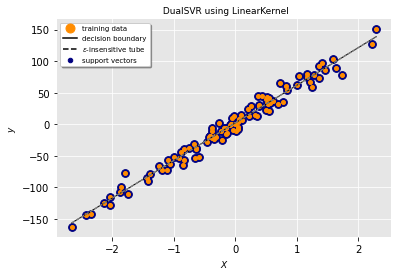

In [86]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, kernel=linear),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_svr_hyperplane.png')

In [87]:
custom_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
custom_linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
cvxopt 1   0.1      0.044434  0.964127      10   100
           0.2      0.040610  0.963709       9   100
           0.3      0.050188  0.963706       9   100
       10  0.1      0.043882  0.977576       8   100
           0.2      0.059017  0.977573       9   100
           0.3      0.037176  0.977573       9    99
       100 0.1      0.057136  0.977515       8   100
           0.2      0.045696  0.977496       9   100
           0.3      0.033306  0.977493       9   100
smo    1   0.1      0.023381  0.964127      17    98
           0.2      0.044661  0.963707      18    96
           0.3      0.035539  0.963707      14    96
       10  0.1      0.137995  0.977576      69   100
           0.2      0.500972  0.977573     749   100
           0.3      0.129166  0.977573      78    99
       100 0.1      0.544417  0.977515     549   100
           0.2      0.471177  0.977496     723   100
           0.3      0.512489  0.977493     926    99

In [88]:
grid = GridSearchCV(SklSVR(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits
[LibSVM]

In [89]:
libsvm_linear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svr_cv_results.set_index(['solver', 'C', 'epsilon'], inplace=True)
libsvm_linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
libsvm 1   0.1      0.003990  0.964103      81    98
           0.2      0.005355  0.963680      81    97
           0.3      0.007024  0.963684      78    96
       10  0.1      0.009187  0.977559     226   100
           0.2      0.005927  0.977554     706   100
           0.3      0.011225  0.977564     181    99
       100 0.1      0.008480  0.977481    1224   100
           0.2      0.017160  0.977450    2126   100
           0.3      0.008723  0.977463    2680    99

In [90]:
linear_dual_svr_cv_results = custom_linear_dual_svr_cv_results.append(libsvm_linear_dual_svr_cv_results)
linear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], ascending=[False, True, True], inplace=True)
linear_dual_svr_cv_results.to_latex('./tex/experiments/linear_dual_svr.tex', 
                                    caption='Linear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                    label='linear_dual_svr_cv_results', position='H')
linear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver C   epsilon                                  
smo    1   0.1      0.023381  0.964127      17    98
           0.2      0.044661  0.963707      18    96
           0.3      0.035539  0.963707      14    96
       10  0.1      0.137995  0.977576      69   100
           0.2      0.500972  0.977573     749   100
           0.3      0.129166  0.977573      78    99
       100 0.1      0.544417  0.977515     549   100
           0.2      0.471177  0.977496     723   100
           0.3      0.512489  0.977493     926    99
libsvm 1   0.1      0.003990  0.964103      81    98
           0.2      0.005355  0.963680      81    97
           0.3      0.007024  0.963684      78    96
       10  0.1      0.009187  0.977559     226   100
           0.2      0.005927  0.977554     706   100
           0.3      0.011225  0.977564     181    99
       100 0.1      0.008480  0.977481    1224   100
           0.2      0.017160  0.977450    2126   100
           0.3      0.008723  0.977463    2680    99
cvxopt 1   0.1      0.044434  0.964127      10   100
           0.2      0.040610  0.963709       9   100
           0.3      0.050188  0.963706       9   100
       10  0.1      0.043882  0.977576       8   100
           0.2      0.059017  0.977573       9   100
           0.3      0.037176  0.977573       9    99
       100 0.1      0.057136  0.977515       8   100
           0.2      0.045696  0.977496       9   100
           0.3      0.033306  0.977493       9   100

##### Nonlinear

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0:  7.3991e+00 -2.2499e+02  2e+02  3e-15  5e-12
 1:  6.0879e+00 -1.3991e+01  2e+01  8e-15  7e-12
 2: -1.6038e-01 -2.9527e+00  3e+00  2e-15  5e-12
 3: -1.6312e+00 -2.1636e+00  5e-01  3e-15  3e-12
 4: -1.8943e+00 -2.0006e+00  1e-01  4e-15  3e-12
 5: -1.9482e+00 -1.9639e+00  2e-02  9e-16  3e-12
 6: -1.9563e+00 -1.9564e+00  2e-04  4e-16  2e-12
 7: -1.9564e+00 -1.9564e+00  2e-06  2e-15  3e-12
Optimal solution found.


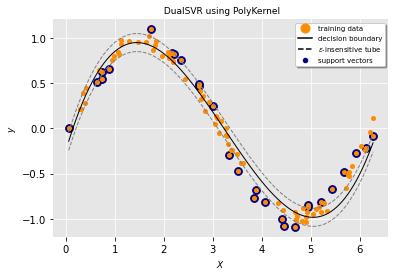

In [91]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_svr_hyperplane.png')

In [92]:
poly_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
poly_nonlinear_dual_svr_cv_results

fit_time        r2   n_iter  n_sv
solver kernel C   epsilon                                      
cvxopt poly   1   0.1         0.087879  0.966650        8    28
                  0.2         0.162963  0.389408       10     6
                  0.3         0.103764  0.070818       10     4
              10  0.1         0.133711  0.824379        9    30
                  0.2         0.139223  0.777645       10     4
                  0.3         0.069593  0.070820       10     4
              100 0.1         0.044351  0.952412        9    72
                  0.2         0.033852  0.777643       10     4
                  0.3         0.036072  0.070818       10     4
smo    poly   1   0.1        16.621604  0.965958    22565    28
                  0.2        10.662649  0.915386    18370     7
                  0.3         2.206419 -0.019348     2577     4
              10  0.1       162.003244  0.873457   269916    29
                  0.2         5.475889  0.773653     7385     4
                  0.3         2.235514 -0.019348     2577     4
              100 0.1      1570.878271  0.873592  2837623    29
                  0.2         5.905676  0.773653     7385     4
                  0.3         1.954492 -0.019348     2577     4

Fitting 1 folds for each of 18 candidates, totalling 18 fits
     pcost       dcost       gap    pres   dres
 0:  9.9728e+02 -2.2564e+04  2e+04  3e-13  4e-13
 1:  8.8676e+02 -1.2896e+03  2e+03  3e-13  5e-13
 2:  1.6801e+02 -1.6779e+02  3e+02  8e-13  3e-13
 3:  3.5709e+01 -5.7124e+01  9e+01  1e-13  2e-13
 4:  4.2114e+00 -3.0100e+01  3e+01  3e-13  1e-13
 5: -8.9533e+00 -1.7585e+01  9e+00  7e-14  1e-13
 6: -1.2997e+01 -1.3920e+01  9e-01  8e-14  1e-13
 7: -1.3407e+01 -1.3483e+01  8e-02  2e-13  1e-13
 8: -1.3443e+01 -1.3444e+01  9e-04  4e-14  1e-13
 9: -1.3443e+01 -1.3443e+01  9e-06  1e-13  1e-13
Optimal solution found.


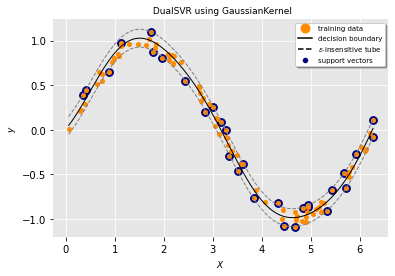

In [93]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_svr_hyperplane.png')

In [94]:
rbf_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svr_cv_results.sort_values(['solver', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
rbf_nonlinear_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
solver kernel C   epsilon                                  
cvxopt rbf    1   0.1      0.042391  0.989236      10    20
                  0.2      0.033710  0.915828       9     6
                  0.3      0.050085  0.858355       9     6
              10  0.1      0.043324  0.987421      10    21
                  0.2      0.032647  0.915828      10     6
                  0.3      0.044080  0.861873      10     5
              100 0.1      0.043129  0.990163      10    29
                  0.2      0.025641  0.915828      10     6
                  0.3      0.046823  0.861873      10     5
smo    rbf    1   0.1      0.162744  0.989251      58    20
                  0.2      0.042457  0.916460      30     6
                  0.3      0.017082  0.863690       7     5
              10  0.1      0.962114  0.988808     855    22
                  0.2      0.023530  0.916260      26     6
                  0.3      0.010618  0.863690       7     5
              100 0.1      4.986097  0.986641    4714    19
                  0.2      0.019692  0.916260      26     6
                  0.3      0.017319  0.863690       7     5

In [95]:
custom_nonlinear_dual_svr_cv_results = poly_nonlinear_dual_svr_cv_results.append(rbf_nonlinear_dual_svr_cv_results)
custom_nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
custom_nonlinear_dual_svr_cv_results

fit_time        r2   n_iter  n_sv
solver kernel C   epsilon                                      
cvxopt poly   1   0.1         0.087879  0.966650        8    28
                  0.2         0.162963  0.389408       10     6
                  0.3         0.103764  0.070818       10     4
              10  0.1         0.133711  0.824379        9    30
                  0.2         0.139223  0.777645       10     4
                  0.3         0.069593  0.070820       10     4
              100 0.1         0.044351  0.952412        9    72
                  0.2         0.033852  0.777643       10     4
                  0.3         0.036072  0.070818       10     4
       rbf    1   0.1         0.042391  0.989236       10    20
                  0.2         0.033710  0.915828        9     6
                  0.3         0.050085  0.858355        9     6
              10  0.1         0.043324  0.987421       10    21
                  0.2         0.032647  0.915828       10     6
                  0.3         0.044080  0.861873       10     5
              100 0.1         0.043129  0.990163       10    29
                  0.2         0.025641  0.915828       10     6
                  0.3         0.046823  0.861873       10     5
smo    poly   1   0.1        16.621604  0.965958    22565    28
                  0.2        10.662649  0.915386    18370     7
                  0.3         2.206419 -0.019348     2577     4
              10  0.1       162.003244  0.873457   269916    29
                  0.2         5.475889  0.773653     7385     4
                  0.3         2.235514 -0.019348     2577     4
              100 0.1      1570.878271  0.873592  2837623    29
                  0.2         5.905676  0.773653     7385     4
                  0.3         1.954492 -0.019348     2577     4
       rbf    1   0.1         0.162744  0.989251       58    20
                  0.2         0.042457  0.916460       30     6
                  0.3         0.017082  0.863690        7     5
              10  0.1         0.962114  0.988808      855    22
                  0.2         0.023530  0.916260       26     6
                  0.3         0.010618  0.863690        7     5
              100 0.1         4.986097  0.986641     4714    19
                  0.2         0.019692  0.916260       26     6
                  0.3         0.017319  0.863690        7     5

In [96]:
grid = GridSearchCV(SklSVR(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [3],
                                 'gamma': ['scale']},
                                {'epsilon': [0.1, 0.2, 0.3],
                                 'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits
[LibSVM]

In [97]:
libsvm_nonlinear_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svr_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svr_cv_results.sort_values(['kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results.set_index(['solver', 'kernel', 'C', 'epsilon'], inplace=True)
libsvm_nonlinear_dual_svr_cv_results

fit_time        r2    n_iter  n_sv
solver kernel C   epsilon                                    
libsvm poly   1   0.1      0.033172  0.982113     58829    28
                  0.2      0.010934  0.974153     15817     7
                  0.3      0.009176  0.946442      2697     4
              10  0.1      0.166147  0.982366    477441    29
                  0.2      0.008310  0.979179      5598     4
                  0.3      0.005829  0.946442      2697     4
              100 0.1      2.230161  0.982119  10669851    29
                  0.2      0.020086  0.979179      5598     4
                  0.3      0.004748  0.946442      2697     4
       rbf    1   0.1      0.009822  0.989178        80    20
                  0.2      0.013293  0.982040        37     6
                  0.3      0.001457  0.951730        18     5
              10  0.1      0.003906  0.990056       833    20
                  0.2      0.007880  0.982014        38     6
                  0.3      0.002544  0.951730        18     5
              100 0.1      0.011858  0.990542     12361    19
                  0.2      0.005540  0.982014        38     6
                  0.3      0.001965  0.951730        18     5

In [98]:
nonlinear_dual_svr_cv_results = custom_nonlinear_dual_svr_cv_results.append(libsvm_nonlinear_dual_svr_cv_results)
nonlinear_dual_svr_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_dual_svr.tex', 
                                       caption='Nonlinear SVR Wolfe Dual formulation results with Epsilon-insensitive loss', 
                                       label='nonlinear_dual_svr_cv_results', position='H')
nonlinear_dual_svr_cv_results

fit_time        r2    n_iter  n_sv
solver kernel C   epsilon                                       
smo    poly   1   0.1        16.621604  0.965958     22565    28
                  0.2        10.662649  0.915386     18370     7
                  0.3         2.206419 -0.019348      2577     4
              10  0.1       162.003244  0.873457    269916    29
                  0.2         5.475889  0.773653      7385     4
                  0.3         2.235514 -0.019348      2577     4
              100 0.1      1570.878271  0.873592   2837623    29
                  0.2         5.905676  0.773653      7385     4
                  0.3         1.954492 -0.019348      2577     4
       rbf    1   0.1         0.162744  0.989251        58    20
                  0.2         0.042457  0.916460        30     6
                  0.3         0.017082  0.863690         7     5
              10  0.1         0.962114  0.988808       855    22
                  0.2         0.023530  0.916260        26     6
                  0.3         0.010618  0.863690         7     5
              100 0.1         4.986097  0.986641      4714    19
                  0.2         0.019692  0.916260        26     6
                  0.3         0.017319  0.863690         7     5
libsvm poly   1   0.1         0.033172  0.982113     58829    28
                  0.2         0.010934  0.974153     15817     7
                  0.3         0.009176  0.946442      2697     4
              10  0.1         0.166147  0.982366    477441    29
                  0.2         0.008310  0.979179      5598     4
                  0.3         0.005829  0.946442      2697     4
              100 0.1         2.230161  0.982119  10669851    29
                  0.2         0.020086  0.979179      5598     4
                  0.3         0.004748  0.946442      2697     4
       rbf    1   0.1         0.009822  0.989178        80    20
                  0.2         0.013293  0.982040        37     6
                  0.3         0.001457  0.951730        18     5
              10  0.1         0.003906  0.990056       833    20
                  0.2         0.007880  0.982014        38     6
                  0.3         0.002544  0.951730        18     5
              100 0.1         0.011858  0.990542     12361    19
                  0.2         0.005540  0.982014        38     6
                  0.3         0.001965  0.951730        18     5
cvxopt poly   1   0.1         0.087879  0.966650         8    28
                  0.2         0.162963  0.389408        10     6
                  0.3         0.103764  0.070818        10     4
              10  0.1         0.133711  0.824379         9    30
                  0.2         0.139223  0.777645        10     4
                  0.3         0.069593  0.070820        10     4
              100 0.1         0.044351  0.952412         9    72
                  0.2         0.033852  0.777643        10     4
                  0.3         0.036072  0.070818        10     4
       rbf    1   0.1         0.042391  0.989236        10    20
                  0.2         0.033710  0.915828         9     6
                  0.3         0.050085  0.858355         9     6
              10  0.1         0.043324  0.987421        10    21
                  0.2         0.032647  0.915828        10     6
                  0.3         0.044080  0.861873        10     5
              100 0.1         0.043129  0.990163        10    29
                  0.2         0.025641  0.915828        10     6
                  0.3         0.046823  0.861873        10     5

#### Lagrangian Dual

##### Linear

In [16]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, kernel=linear, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'reg_bias': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 18 candidates, totalling 18 fits


In [17]:
linear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'C'], ascending=[False, True], inplace=True)
linear_lagrangian_dual_svr_cv_results.set_index(['dual', 'C', 'epsilon'], inplace=True)
linear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svr.tex', 
                                               caption='Linear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                               label='linear_lagrangian_dual_svr_cv_results', position='H')
linear_lagrangian_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
dual C   epsilon                                  
qp   1   0.1      1.138390  0.731400    1000   100
         0.2      1.259378  0.731400    1000   100
         0.3      1.145181  0.731400    1000   100
     10  0.1      0.953196  0.731400    1000   100
         0.2      1.116884  0.731400    1000   100
         0.3      1.346315  0.731400    1000   100
     100 0.1      1.268649  0.731400    1000   100
         0.2      1.016300  0.731400    1000   100
         0.3      1.278405  0.731400    1000   100
bcqp 1   0.1      1.681605  0.733183    1000   100
         0.2      1.076056  0.733183    1000   100
         0.3      1.286736  0.733183    1000   100
     10  0.1      1.470822  0.733183    1000   100
         0.2      1.387297  0.733183    1000   100
         0.3      1.697497  0.733183    1000   100
     100 0.1      1.848502  0.733183    1000   100
         0.2      1.179248  0.733183    1000   100
         0.3      1.196528  0.733183    1000   100

##### Nonlinear

In [18]:
grid = GridSearchCV(DualSVR(loss=epsilon_insensitive, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=3, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'reg_bias': [True, False]},
                    scoring=dual_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 36 candidates, totalling 36 fits


In [19]:
nonlinear_lagrangian_dual_svr_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svr_cv_results.sort_values(['dual', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.set_index(['dual', 'kernel', 'C', 'epsilon'], inplace=True)
nonlinear_lagrangian_dual_svr_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svr.tex', 
                                                  caption='Nonlinear SVR Lagrangian Dual formulation results with Epsilon-insensitive loss', 
                                                  label='nonlinear_lagrangian_dual_svr_cv_results', position='H')
nonlinear_lagrangian_dual_svr_cv_results

fit_time        r2  n_iter  n_sv
dual kernel C   epsilon                                  
qp   poly   1   0.1      1.426305  0.536892    1000   100
                0.2      1.947305  0.536886    1000   100
                0.3      1.597898  0.529220    1000   100
            10  0.1      1.569864  0.536892    1000   100
                0.2      1.659373  0.536886    1000   100
                0.3      2.155713  0.529220    1000   100
            100 0.1      2.127201  0.536892    1000   100
                0.2      2.003470  0.536886    1000   100
                0.3      1.385318  0.529220    1000   100
     rbf    1   0.1      0.333465  0.733767     128   100
                0.2      1.326574  0.718224     640   100
                0.3      2.035441  0.580564    1000   100
            10  0.1      0.369488  0.733767     128   100
                0.2      1.663891  0.718224     640   100
                0.3      1.971318  0.580564    1000   100
            100 0.1      0.366429  0.733767     128   100
                0.2      1.615145  0.718224     640   100
                0.3      1.913055  0.580564    1000   100
bcqp poly   1   0.1      1.363023  0.536344    1000   100
                0.2      1.468118  0.536338    1000   100
                0.3      1.414094  0.528759    1000   100
            10  0.1      1.700776  0.536344    1000   100
                0.2      1.394834  0.536338    1000   100
                0.3      1.842973  0.528759    1000   100
            100 0.1      2.344345  0.536344    1000   100
                0.2      1.843466  0.536338    1000   100
                0.3      1.377408  0.528759    1000   100
     rbf    1   0.1      3.017241  0.739809    1000   100
                0.2      0.320919  0.717846     165   100
                0.3      0.398222  0.632389     185   100
            10  0.1      2.460307  0.739809    1000   100
                0.2      0.334468  0.717846     165   100
                0.3      0.389869  0.632389     185   100
            100 0.1      2.811035  0.739809    1000   100
                0.2      0.336349  0.717846     165   100
                0.3      0.400294  0.632389     185   100

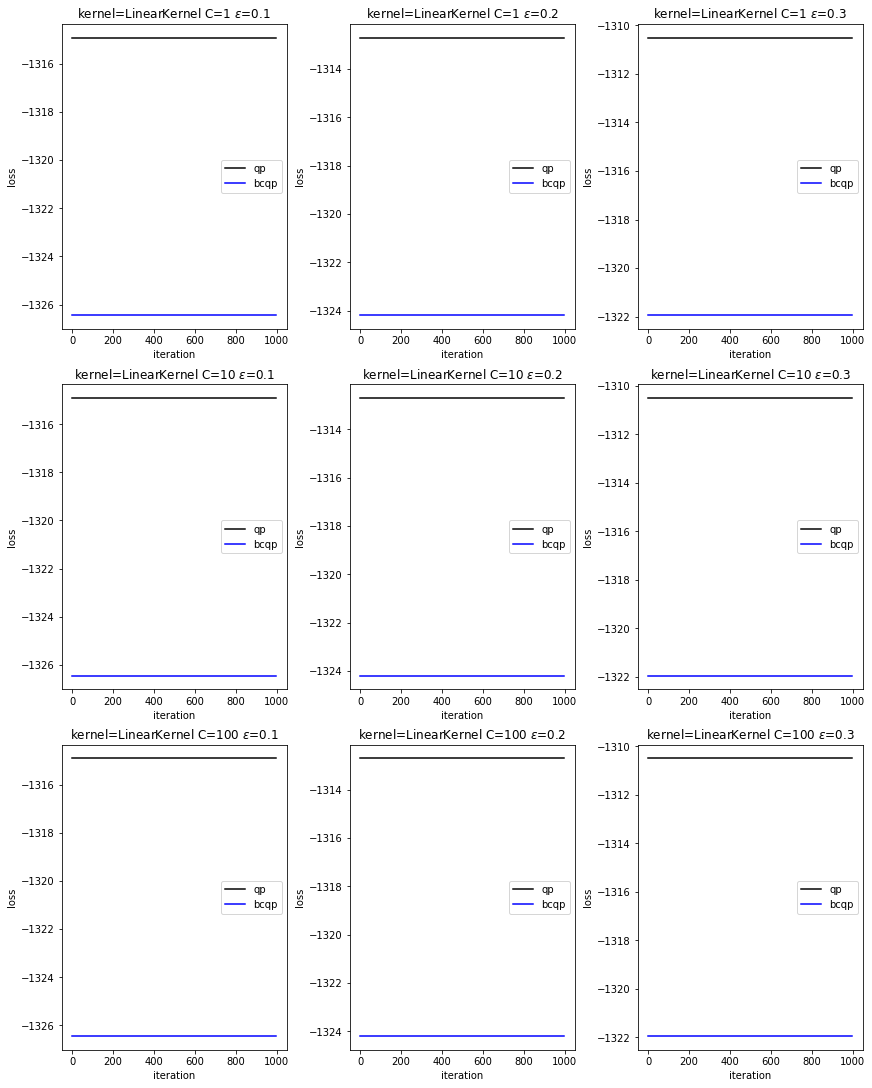

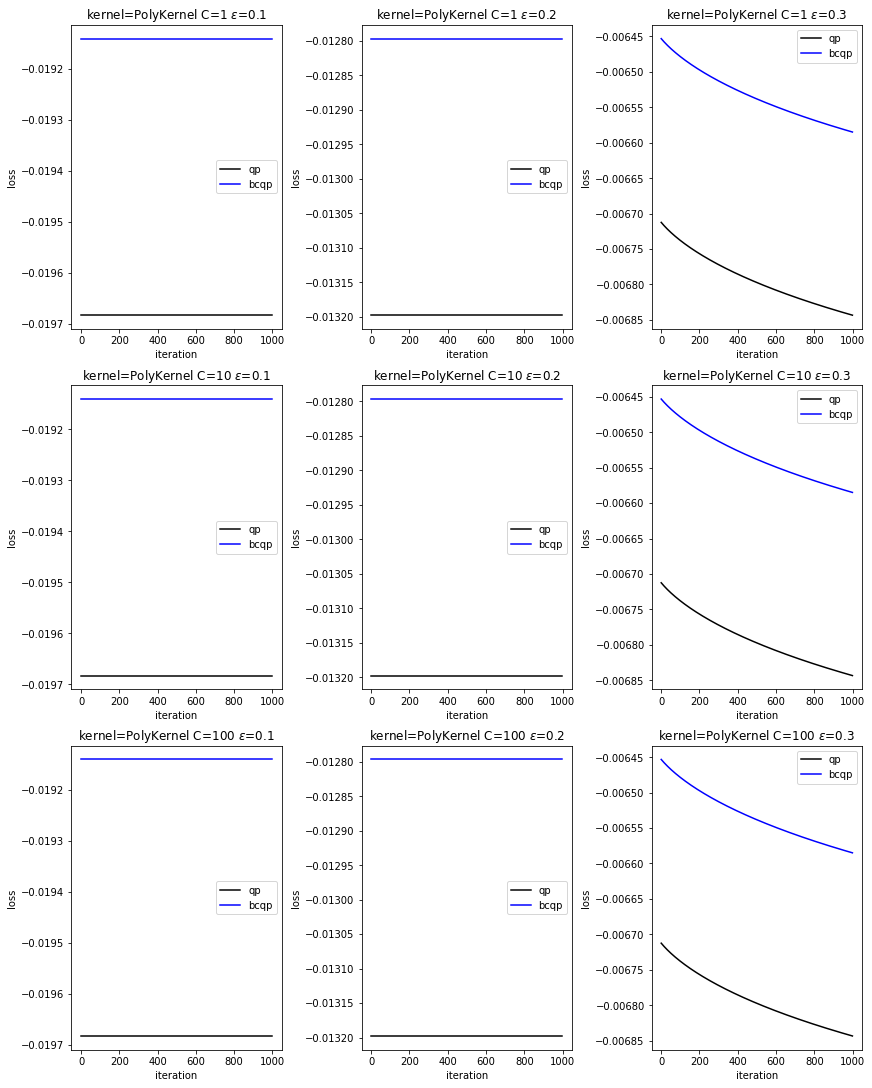

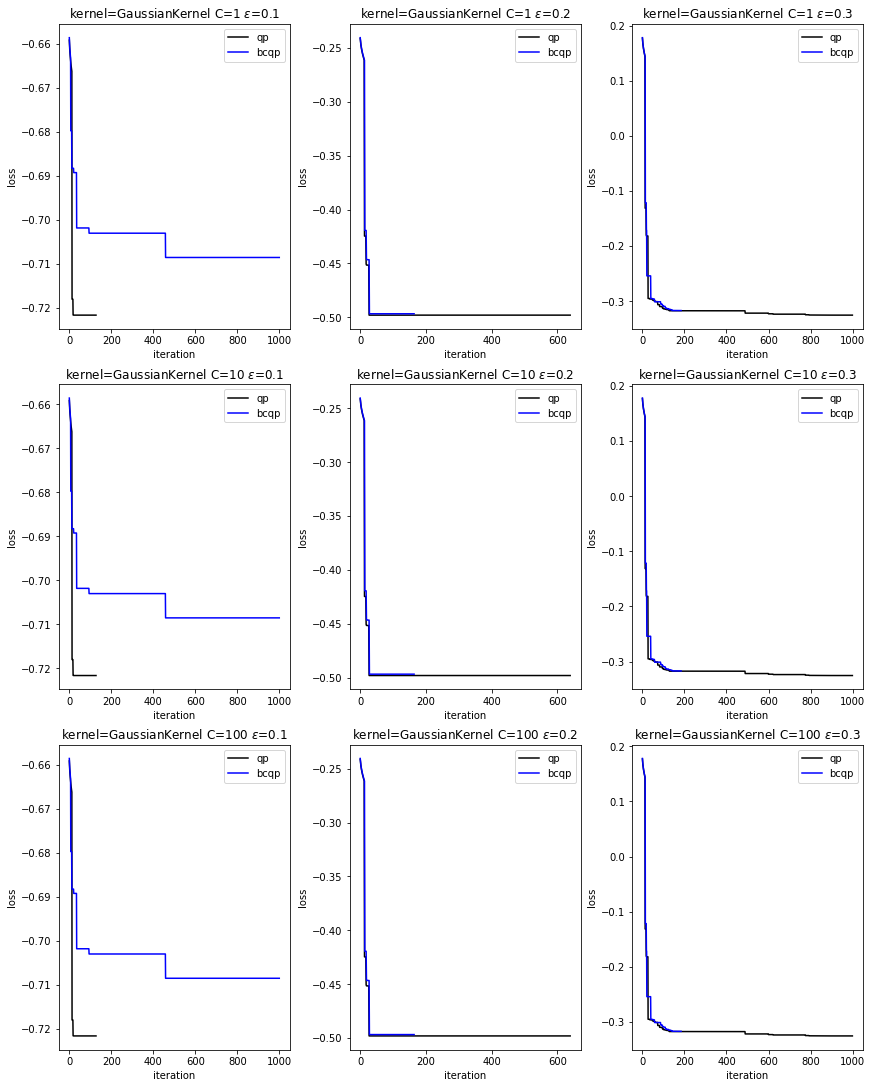

In [24]:
colors = {'reg_bias': 'k',
          'unreg_bias': 'b'}
linear_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
linear_ax = linear_fig.subplots(3, 3)
poly_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
poly_ax = poly_fig.subplots(3, 3)
gaussian_fig = plt.figure(figsize=(12, 15), constrained_layout=True)
gaussian_ax = gaussian_fig.subplots(3, 3)
axes = {'LinearKernel': linear_ax,
        'PolyKernel': poly_ax,
        'GaussianKernel': gaussian_ax}
for dual, _dict1 in train_loss_history.items():
    for kernel, _dict2 in _dict1.items():
        for (C, _dict3), row_ax in zip(_dict2.items(), axes[kernel]):
            for (eps, history), loss in zip(_dict3.items(), row_ax):
                loss.plot(history, color=colors[dual])
                loss.set_title('kernel={} C={:d} $\epsilon$={:.1f}'.format(kernel, C, eps))
                loss.set_xlabel('iteration')
                loss.set_ylabel('loss')
                loss.legend(colors.keys()).get_frame().set_facecolor('white')
linear_fig.savefig('./tex/img/lagrangian_dual_linear_svr_loss_history.png')
poly_fig.savefig('./tex/img/lagrangian_dual_poly_svr_loss_history.png')
gaussian_fig.savefig('./tex/img/lagrangian_dual_gaussian_svr_loss_history.png')

## Squared Epsilon-insensitive loss

### Primal formulation

In [56]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVR as SkLinearSVR
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [57]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def primal_r2_scorer(svr, X, y):
    if hasattr(svr, 'train_loss_history'):
        train_loss_history[svr.momentum_type][svr.C][svr.epsilon] = svr.train_loss_history
    return {'r2': svr.score(X, y), 
            'n_iter': svr.n_iter_ if isinstance(svr, SkLinearSVR) else svr.optimizer.epoch, 
            'n_sv': len(np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel())}

Fitting 1 folds for each of 9 candidates, totalling 9 fits


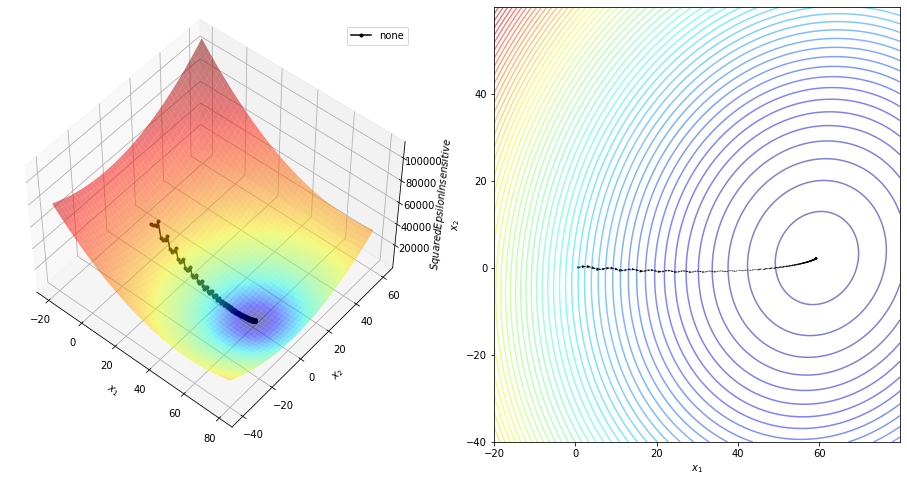

In [58]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='none', learning_rate=0.001, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-20, x_max=80, y_min=-40, y_max=60)
squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss, grid.best_estimator_.optimizer, 
                                                    color='k', label='none')

In [59]:
none_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
none_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'none')
none_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
none_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      1.030746  0.977019     652   100
                    0.2      0.997807  0.977008     655    99
                    0.3      1.043000  0.976996     657    99
                10  0.1      0.099664  0.977572      75    99
                    0.2      0.098767  0.977572      75    99
                    0.3      0.101691  0.977571      76    99
                100 0.1      0.016646  0.977413       8   100
                    0.2      0.017631  0.977418       9    99
                    0.3      0.016503  0.977423       9    98

Fitting 1 folds for each of 9 candidates, totalling 9 fits


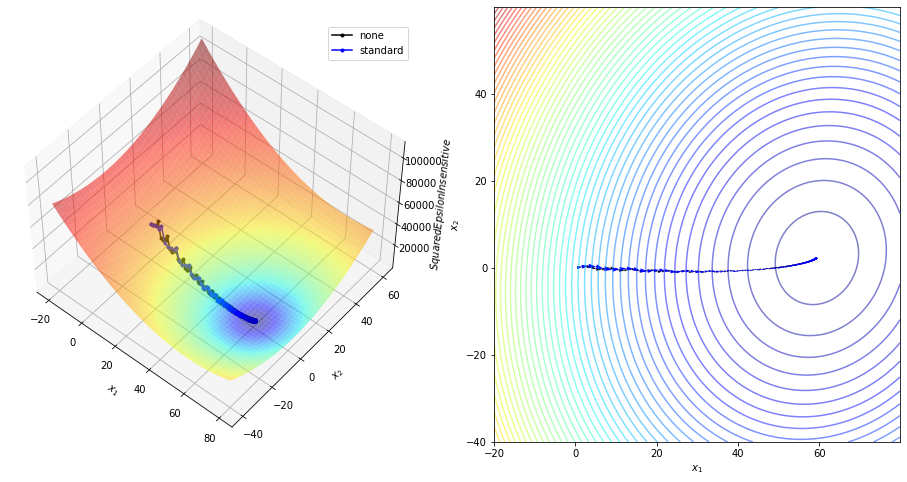

In [60]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='standard', momentum=0.4, learning_rate=0.001, batch_size=20, 
                              early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='b', label='standard')
squared_eps_loss_opt

In [61]:
standard_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
standard_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    standard 1   0.1      0.846578  0.977028     405   100
                    0.2      0.540464  0.977018     407    99
                    0.3      0.469960  0.977006     408    99
                10  0.1      0.073722  0.977572      42    99
                    0.2      0.096979  0.977571      42    99
                    0.3      0.083027  0.977571      43    99
                100 0.1      0.011127  0.977443       6    99
                    0.2      0.010332  0.977447       6    99
                    0.3      0.010090  0.977450       6    97

Fitting 1 folds for each of 9 candidates, totalling 9 fits


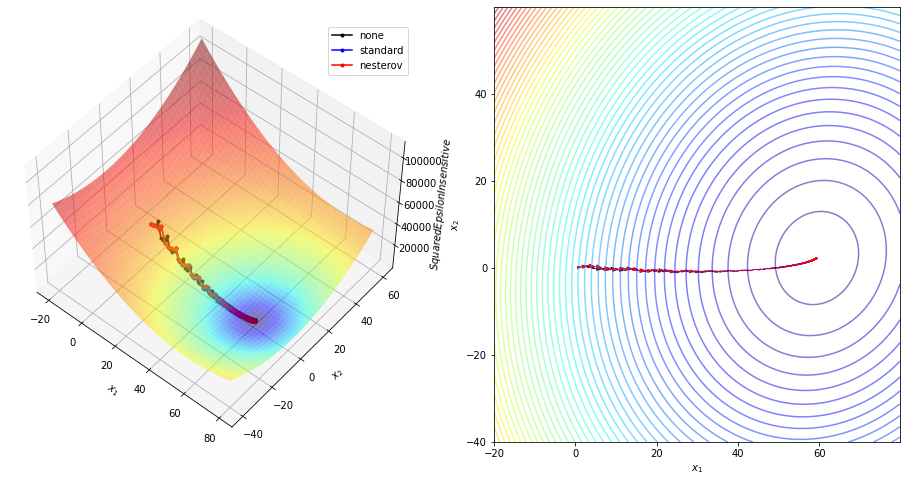

In [62]:
grid = GridSearchCV(PrimalSVR(loss=squared_epsilon_insensitive, optimizer=StochasticGradientDescent, 
                              momentum_type='nesterov', momentum=0.4, learning_rate=0.001, batch_size=20, 
                              early_stopping=True, random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_eps_loss_opt = plot_trajectory_optimization(squared_eps_loss_opt, grid.best_estimator_.optimizer, 
                                                    color='r', label='nesterov')
squared_eps_loss_opt.savefig('./tex/img/svr_squared_eps_loss.png')
squared_eps_loss_opt

In [63]:
nesterov_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svr_squared_eps_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
nesterov_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    nesterov 1   0.1      0.651231  0.977028     406   100
                    0.2      0.700355  0.977018     408    99
                    0.3      0.680427  0.977006     409    99
                10  0.1      0.061513  0.977572      43    99
                    0.2      0.069752  0.977571      43    99
                    0.3      0.086758  0.977570      43    99
                100 0.1      0.015766  0.977417       6   100
                    0.2      0.019734  0.977423       6    99
                    0.3      0.016762  0.977428       6    98

In [64]:
custom_primal_svr_squared_eps_cv_results = none_primal_svr_squared_eps_cv_results.append(
    standard_primal_svr_squared_eps_cv_results).append(
    nesterov_primal_svr_squared_eps_cv_results)
custom_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver momentum C   epsilon                                  
sgd    none     1   0.1      1.030746  0.977019     652   100
                    0.2      0.997807  0.977008     655    99
                    0.3      1.043000  0.976996     657    99
                10  0.1      0.099664  0.977572      75    99
                    0.2      0.098767  0.977572      75    99
                    0.3      0.101691  0.977571      76    99
                100 0.1      0.016646  0.977413       8   100
                    0.2      0.017631  0.977418       9    99
                    0.3      0.016503  0.977423       9    98
       standard 1   0.1      0.846578  0.977028     405   100
                    0.2      0.540464  0.977018     407    99
                    0.3      0.469960  0.977006     408    99
                10  0.1      0.073722  0.977572      42    99
                    0.2      0.096979  0.977571      42    99
                    0.3      0.083027  0.977571      43    99
                100 0.1      0.011127  0.977443       6    99
                    0.2      0.010332  0.977447       6    99
                    0.3      0.010090  0.977450       6    97
       nesterov 1   0.1      0.651231  0.977028     406   100
                    0.2      0.700355  0.977018     408    99
                    0.3      0.680427  0.977006     409    99
                10  0.1      0.061513  0.977572      43    99
                    0.2      0.069752  0.977571      43    99
                    0.3      0.086758  0.977570      43    99
                100 0.1      0.015766  0.977417       6   100
                    0.2      0.019734  0.977423       6    99
                    0.3      0.016762  0.977428       6    98

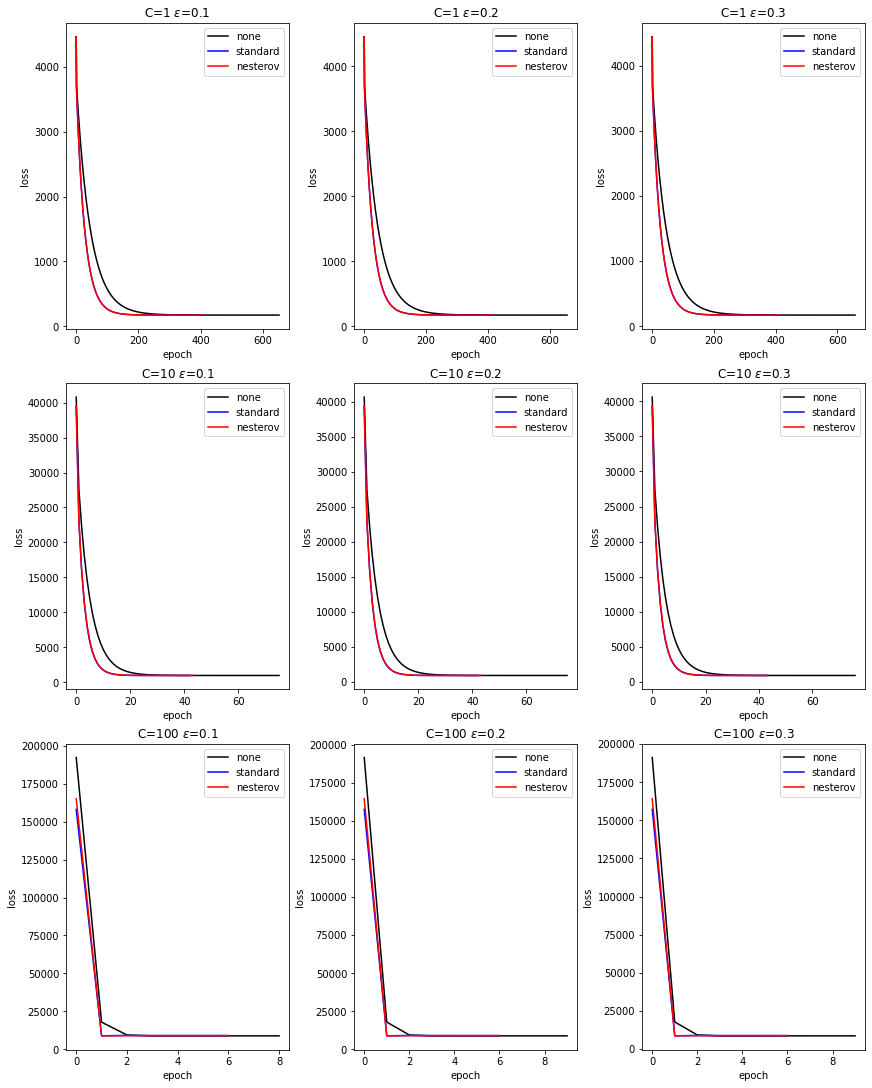

In [65]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(12, 15), constrained_layout=True).subplots(3, 3)
for momentum, _dict1 in train_loss_history.items():
    for (C, _dict2), row_ax in zip(_dict1.items(), axes):
        for (eps, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[momentum])
            loss.set_title('C={:d} $\epsilon$={:.1f}'.format(C, eps))
            loss.set_xlabel('epoch')
            loss.set_ylabel('loss')
            loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/svr_squared_eps_loss_history.png')

In [66]:
grid = GridSearchCV(SkLinearSVR(loss='squared_epsilon_insensitive', random_state=2),
                    param_grid={'epsilon': [0.1, 0.2, 0.3],
                                'C': [1, 10, 100]},
                    scoring=primal_r2_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='r2',  # refit the best model (wrt r2) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 9 candidates, totalling 9 fits


In [67]:
liblinear_primal_svr_squared_eps_cv_results = filter_svr_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svr_squared_eps_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svr_squared_eps_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svr_squared_eps_cv_results.set_index(['solver', 'momentum', 'C', 'epsilon'], inplace=True)
liblinear_primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
liblinear -        1   0.1      0.001741  0.977554      96   100
                       0.2      0.001646  0.977553      96   100
                       0.3      0.001372  0.977551      96   100
                   10  0.1      0.004879  0.977577     826   100
                       0.2      0.004877  0.977576     826    99
                       0.3      0.005020  0.977576     839    99
                   100 0.1      0.007763  0.977538    1000   100
                       0.2      0.005849  0.977540    1000    99
                       0.3      0.006453  0.977541    1000    98

In [68]:
primal_svr_squared_eps_cv_results = custom_primal_svr_squared_eps_cv_results.append(liblinear_primal_svr_squared_eps_cv_results)
primal_svr_squared_eps_cv_results.to_latex('./tex/experiments/primal_svr_squared_eps.tex', 
                                           caption='SVR Primal formulation results with Squared Epsilon-insensitive loss', 
                                           label='primal_svr_squared_eps_cv_results', position='H')
primal_svr_squared_eps_cv_results

fit_time        r2  n_iter  n_sv
solver    momentum C   epsilon                                  
sgd       none     1   0.1      1.030746  0.977019     652   100
                       0.2      0.997807  0.977008     655    99
                       0.3      1.043000  0.976996     657    99
                   10  0.1      0.099664  0.977572      75    99
                       0.2      0.098767  0.977572      75    99
                       0.3      0.101691  0.977571      76    99
                   100 0.1      0.016646  0.977413       8   100
                       0.2      0.017631  0.977418       9    99
                       0.3      0.016503  0.977423       9    98
          standard 1   0.1      0.846578  0.977028     405   100
                       0.2      0.540464  0.977018     407    99
                       0.3      0.469960  0.977006     408    99
                   10  0.1      0.073722  0.977572      42    99
                       0.2      0.096979  0.977571      42    99
                       0.3      0.083027  0.977571      43    99
                   100 0.1      0.011127  0.977443       6    99
                       0.2      0.010332  0.977447       6    99
                       0.3      0.010090  0.977450       6    97
          nesterov 1   0.1      0.651231  0.977028     406   100
                       0.2      0.700355  0.977018     408    99
                       0.3      0.680427  0.977006     409    99
                   10  0.1      0.061513  0.977572      43    99
                       0.2      0.069752  0.977571      43    99
                       0.3      0.086758  0.977570      43    99
                   100 0.1      0.015766  0.977417       6   100
                       0.2      0.019734  0.977423       6    99
                       0.3      0.016762  0.977428       6    98
liblinear -        1   0.1      0.001741  0.977554      96   100
                       0.2      0.001646  0.977553      96   100
                       0.3      0.001372  0.977551      96   100
                   10  0.1      0.004879  0.977577     826   100
                       0.2      0.004877  0.977576     826    99
                       0.3      0.005020  0.977576     839    99
                   100 0.1      0.007763  0.977538    1000   100
                       0.2      0.005849  0.977540    1000    99
                       0.3      0.006453  0.977541    1000    98